# Modelos (ingenuos) generativos de texto

En este notebook, usaremos los conceptos de probabilidad (condicional) y n-gramas para generar texto (similar a como lo hace ChatGPT o Gemini).

In [2]:
# Librerías que utilizaremos
from collections import Counter, defaultdict

import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

import requests

np.random.seed(1)

/Users/pedrom2/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Carga de un libro

In [3]:
# Por ejemplo, considera Drácula
response = requests.get("https://www.gutenberg.org/cache/epub/345/pg345.txt")
libro = response.text.lower()
libro = re.sub('[^ña-z]+', ' ', libro)

print(libro[9_720:10_000])

 had been sent in a letter and that was all he knew when i asked him if he knew count dracula and could tell me anything of his castle both he and his wife crossed themselves and saying that they knew nothing at all simply refused to speak further it was so near the time of start


## Distribución empírica de las palabras

In [4]:
frecuencias_palabras = Counter(libro.split())

print('Palabras únicas: ', len(frecuencias_palabras))
frecuencias_palabras.most_common(10)

Palabras únicas:  9500


[('the', 8104),
 ('and', 5974),
 ('i', 4844),
 ('to', 4746),
 ('of', 3754),
 ('a', 3015),
 ('he', 2583),
 ('in', 2571),
 ('that', 2503),
 ('it', 2190)]

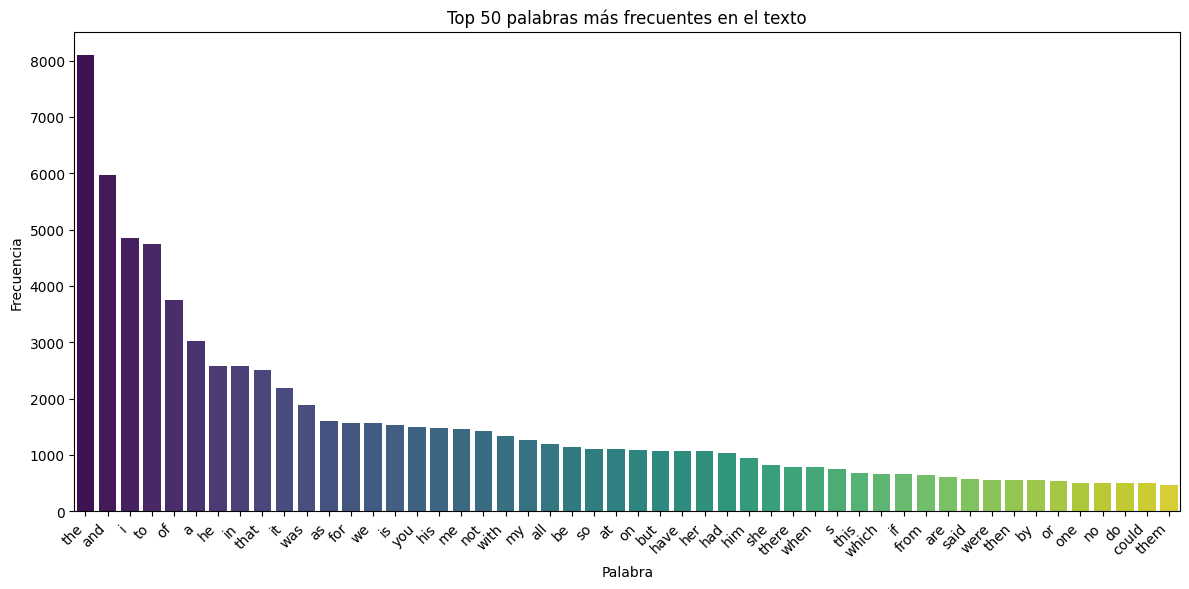

In [33]:
# Obtener las n palabras más comunes
n = 50
palabras_mas_comunes = frecuencias_palabras.most_common(n)
vocabulario, frecuencias = zip(*palabras_mas_comunes)

# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(x=list(vocabulario), y=list(frecuencias), palette='viridis', hue=list(vocabulario), legend=False)
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {n} palabras más frecuentes en el texto")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## N-gramas

Los *n*-gramas son secuencias de $n$ elementos consecutivos (como palabras o caracteres) en un texto, y nos permiten capturar **patrones locales**. 

In [14]:
def genera_texto_npalabras(lista_palabras, n=1, tot_palabras = 100):
    '''Devuelve un texto, utilizando ngramas de palabras
    n es la cantidad de palabras que se toman en consideración para
    generar la siguiente'''

    # Diccionario que guarda para cada ngrama las palabras que le siguen
    dic_ngramas = defaultdict(list) # {(i, am): [the, one, Pedro]}

    for i in range(len(lista_palabras) - n):
        ngram = ' '.join(lista_palabras[i:i+n])
        dic_ngramas[ngram].append(lista_palabras[i+n])

    ngrama = np.random.choice(list(dic_ngramas.keys()))
    texto_generado = ngrama

    # Generación del texto
    for i in range(tot_palabras):
        if ngrama not in dic_ngramas.keys():
            break
        siguiente_palabra = np.random.choice(dic_ngramas[ngrama])     # elige una palabra de la lista de palabras posibles despues del ngrama
        texto_generado += ' ' + siguiente_palabra
        sec_palabras = texto_generado.split()
        ngrama = ' '.join(sec_palabras[len(sec_palabras)-n:len(sec_palabras)])
    return texto_generado

La probabilidad empírica de una palabra $w$ se estima como:

$$
P(w) \approx \frac{\text{count}(w)}{\text{total de palabras}}
$$

La probabilidad condicional de una palabra $w_2$ dado que fue precedida por $w_1$ se estima como:

$$
P(w_2 \mid w_1) \approx \frac{\text{count}(w_1, w_2)}{\text{count}(w_1)}
$$

Esto nos permite construir un modelo generativo a partir de un corpus. Primero obtenemos la distribución de frecuencias de las bigramas. Luego, usamos estas frecuencias como aproximaciones de las probabilidades condicionales entre palabras consecutivas.


## Generación de texto

### Muestreando de la distribución empiríca

In [32]:
' '.join(np.random.choice(vocabulario, 20))  #distribución uniforme

'of the her my is me in to me her be he it was we he on he his his'

### Cómo generar texto con bigramas

1. Empieza con una palabra inicial, por ejemplo, "the".

2. Usa la distribución empírica $ P(w_2 \mid w_1 = \text{"the"}) $ para **muestrear la siguiente palabra**.

3. Toma esa palabra generada y repite el proceso: muestreas $ P(w_3 \mid w_2) $ usando la palabra recién obtenida como contexto.

In [28]:
genera_texto_npalabras(libro.split(), 1, 20)  #Distribución condicionada a la palabra anterior

'unfettered and flared the count never so much as he suddenly stopped suddenly desire took me and as she did not'

### Con trigramas

La probabilidad condicional de la palabra $ w_3 $ dado el par de palabras anteriores $ (w_1, w_2) $ se estima como:

$$
P(w_3 \mid w_1, w_2) \approx \frac{\text{count}(w_1, w_2, w_3)}{\text{count}(w_1, w_2)}
$$

**Pasos para generar texto con trigramas:**

1. Comenzar con dos palabras iniciales, por ejemplo, $ w_1 $ y $ w_2 $.

2. Muestrear la siguiente palabra $ w_3 $ según la distribución $ P(w_3 \mid w_1, w_2) $.

3. Repetir usando las dos últimas palabras generadas como nuevo contexto: $ (w_2, w_3) $, y así sucesivamente.


In [29]:
genera_texto_npalabras(libro.split(), 2, 20) 

'a palpitating wound the next train i found him lying on his entering the room bright and radiant and we shall go'

### Y así sucesivamente...

In [30]:
genera_texto_npalabras(libro.split(), 3, 20) 

'our task is now in reality more difficult than ever and it has become a habit for van helsing had given me to'

### ¿Qué pasa si $n \rightarrow \infty$?

In [ ]:
# Recordatorio para mí: NO CORRER
genera_texto_npalabras(libro.split(), 100, 20) 

'fellow is dead mrs harker raised her head looking from one to the other of us she said solemnly god s will be done i could not but feel that art was keeping back something but as i took it that it was with a purpose i said nothing van helsing turned to morris and asked and you friend quincey have you any to tell a little he answered it may be much eventually but at present i can t say i thought it well to know if possible where the count would go when he left the house i did not see him but i saw a bat rise from renfield s window and flap westward i expected to'

https://www.pagebypagebooks.com/Bram_Stoker/Dracula/CHAPTER_21_p9.html